In [60]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import tensorflow as tf

In [2]:
#makes the random numbers predictable
np.random.seed(0)

In [15]:
#the data is pickle file (serialized)
with open ('Data/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open ('Data/valid.p', 'rb') as f:
    valid_data = pickle.load(f)
with open ('Data/test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [16]:
#train : 34799 images, dimension 32*32 , depth 3 (rgb color)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [17]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(34799,)
(4410,)
(12630,)


In [21]:
data = pd.read_csv('Data/signnames.csv')

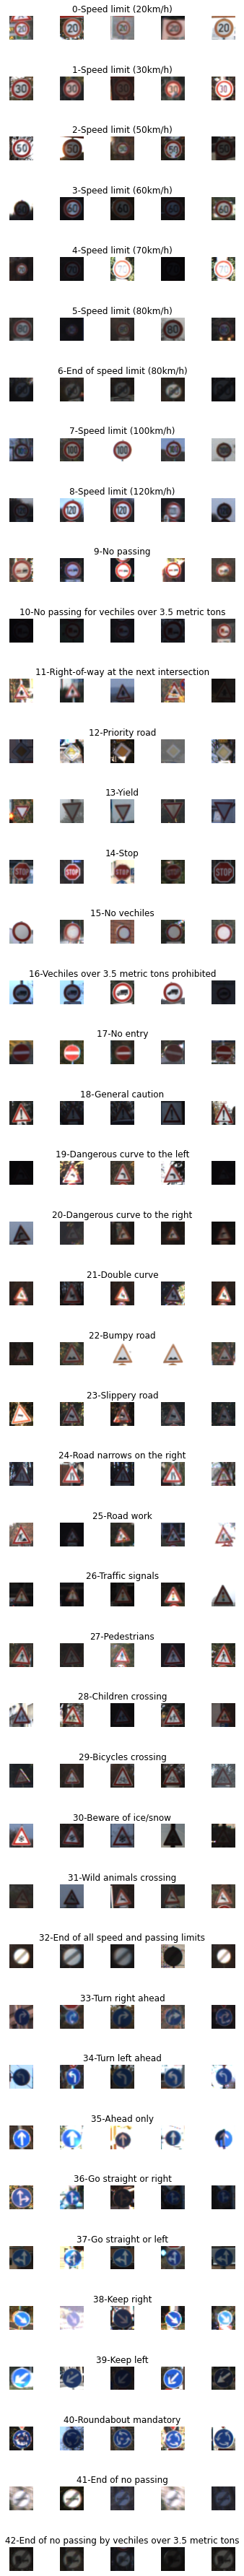

In [24]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '-' + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

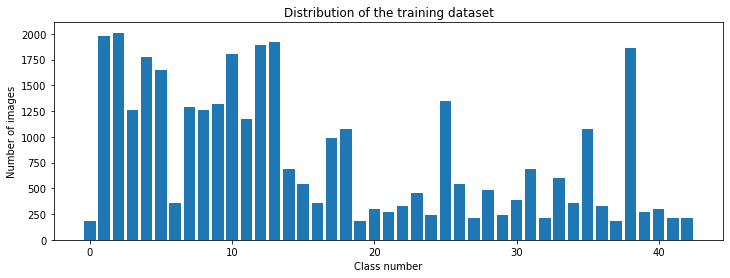

In [25]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

In [31]:
import cv2

(32, 32, 3)
36


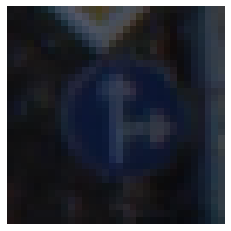

In [28]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print (y_train[1000])

In [34]:
#convert rgb image to gray image because colors are not important features ==> reduce depth ==> neural network
#with less parameters ==> neural network more efficient
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


(32, 32)


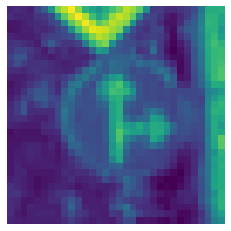

In [38]:
test = grayscale(X_train[1000])
plt.imshow(test)
plt.axis("off")
print(test.shape)

In [39]:
#histogram equalization: increase of constrat, defines better the features in the image
#equalizeHist only accept gray images (immages with depth 1)
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


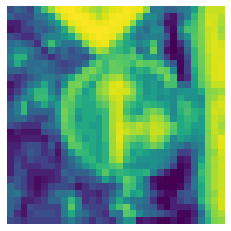

In [40]:
test = equalize(test)
plt.imshow(test)
plt.axis("off")
print(test.shape)

In [41]:
def preprocesing(img):
    img = grayscale(img)
    img = equalize(img)
    #normalization : all pixels between 0 and 1
    img = img/255
    return img

In [42]:
X_train = np.array(list(map(preprocesing, X_train)))
X_val = np.array(list(map(preprocesing, X_val)))
X_test = np.array(list(map(preprocesing,  X_test)))

(34799, 32, 32)


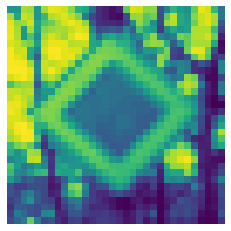

In [46]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [47]:
""" 
CNN : apply a filter to the channel of the image
(34799, 32, 32) ==> 1 channel is present
Add depth to the data
"""
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [48]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


(34799, 32, 32, 1)


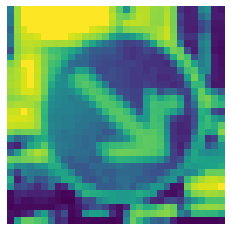

In [49]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [51]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_train, 43)
y_val = to_categorical(y_train, 43)

In [55]:
def leNet_model():
    model = Sequential()
    #convolutional 2D consist of filters that recognize features from the image
    #30 filters - (5, 5) size of the filter - (32, 32, 1) shape of the input image
    model.add(Conv2D(30, (5, 5) ,input_shape= (32, 32, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(15, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #reshape the output into 1D array of shape 540 = 6*6*15
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    #compile model
    model.compile(Adam(lr = 0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


In [56]:
model = leNet_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 30)        780       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 30)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 15)        4065      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 15)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 540)               0         
                                                                 
 dense_2 (Dense)             (None, 500)              

c:\Users\bouzi\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [67]:
!nvidia-smi

Sun Oct 30 16:31:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P0    16W /  N/A |   1574MiB /  6144MiB |     54%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [66]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
else:
  print("No GPU device found")

No GPU device found


In [ ]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [63]:
model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Epoch 1/10
28/87 [========>.....................] - ETA: 5s - loss: 0.4473 - accuracy: 0.8554

KeyboardInterrupt: 